In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
)

customer = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                                              'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                              'order_estimated_delivery_date'])


# Notes
 - Cusomter id is akin to order it - it is unique per order
 - Cusomter unique id work like a normal customer id (i.e. it identifies unique user)
 - Order status has 8 statuses of which delivered has the highest frequency

In [19]:
orders_clean = (
    orders
    # keep orders where order has EVER HAD status delivered
    .query("order_purchase_timestamp.notnull()")
)

In [20]:
orders_wth_user = (
    orders_clean
    .merge(
        customer[['customer_id', 'customer_unique_id']], 
        on = 'customer_id', 
        how = 'left'
    )
)

## Task 1

In [21]:
(
    orders_wth_user
    .groupby('customer_unique_id', as_index=False)
    .agg(orders = ('order_id', 'nunique'))
    .query('orders == 1')
    .customer_unique_id
    .nunique()
)
# answer - 90545 unique users who have made only ONE order


93099

## Task 2

In [22]:

(
    orders
    .assign(month = orders.order_estimated_delivery_date.values.astype('datetime64[M]'))
    .groupby(['order_status', 'month'], as_index=False)
    .agg(orders = ('order_id', 'nunique'))
    .assign(unique_months = lambda x: x.month.nunique())
    .groupby('order_status', as_index=False)
    .agg(
        orders = ('orders', 'sum'),
        months = ('unique_months', 'mean')
    )
    .assign(avg_order_per_month = lambda x: x.orders/x.months)
    .sort_values(by='avg_order_per_month', ascending=False)
    .query("order_status != 'delivered'")
)

,order_status,orders,months,avg_order_per_month
6,shipped,1107,27.0,41.000000
1,canceled,625,27.0,23.148148
7,unavailable,609,27.0,22.555556
4,invoiced,314,27.0,11.629630
5,processing,301,27.0,11.148148
2,created,5,27.0,0.185185
0,approved,2,27.0,0.074074


## Task 3

In [23]:
(
    order_items
    .merge(orders[['order_id', 'order_purchase_timestamp']], on = 'order_id', how = 'left')
    .assign(weekday = lambda x: x.order_purchase_timestamp.dt.day_name())
    .groupby(['product_id','weekday'], as_index=False)
    .agg(purchases = ('order_id','count'))
    .sort_values(by=['product_id','purchases'], ascending=False)
    .groupby('product_id', as_index=False)
    .head(1)
)

,product_id,weekday,purchases
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
61224,fff9553ac224cec9d15d49f5a263411f,Friday,1
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
61221,fff6177642830a9a94a0f2cba5e476d1,Saturday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


## Task 4

In [169]:
### Take number of days in month (https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.daysinmonth.html) AND divide by 7 for average

In [170]:
(
    orders_clean
    .assign(
        month = lambda x: x.order_estimated_delivery_date.dt.month,
        firstday_in_month = lambda x: x.order_estimated_delivery_date - pd.to_timedelta(x.order_estimated_delivery_date.dt.day - 1, unit='d'),
        b = lambda x: x.order_estimated_delivery_date.dt.day-1 ,
        c = lambda x: x.firstday_in_month.dt.weekday,
        month_week = lambda x: weekinmonth(x.order_estimated_delivery_date)
        #week_days = 
    )
    .sort_values('month_week')
)



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,firstday_in_month,b,c,month_week
59989,8b5512b2679b86761e6aadc28ed91762,ee2eee66d80a60f1761eedb7599a971d,delivered,2018-08-03 14:39:54,2018-08-03 14:50:14,2018-08-03 13:57:00,2018-08-22 18:03:43,2018-10-01,10,2018-10-01,0,0,0
9930,c571e33a662a6379681a73ca764dc4e4,e0f4b0b83c7a96648a38e1f0820ce120,delivered,2018-08-17 12:16:27,2018-08-17 12:30:29,2018-08-20 14:30:00,2018-08-29 23:06:27,2018-10-01,10,2018-10-01,0,0,0
46661,a531f18d52ebc430be165b4ea5a7bf5b,f2fc5c6aa68766fc4dad7fcec0da798f,delivered,2018-08-21 23:58:53,2018-08-22 00:10:19,2018-08-22 14:16:00,2018-08-28 20:44:33,2018-10-01,10,2018-10-01,0,0,0
80062,4d680edbaa7d3d9bed69532957368a03,1444f701e835b7d189637c10f5287e76,delivered,2018-08-20 14:34:51,2018-08-21 09:15:09,2018-08-23 09:21:00,2018-08-27 17:51:52,2018-10-01,10,2018-10-01,0,0,0
85668,2f72a08e8fc765e47fd2f4f2eb7a3704,b2094bed49f0b4ad05a770234d42af20,delivered,2018-08-23 10:47:14,2018-08-24 04:05:12,2018-08-24 11:53:00,2018-08-29 19:06:43,2018-10-01,10,2018-10-01,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,57a8a1ca9bc2b0e04db9384fa04d23e9,63334b89dcbdc243ea796e9549431458,delivered,2017-09-28 12:03:57,2017-09-28 12:24:29,2017-10-02 21:26:54,2017-10-18 20:59:42,2017-10-31,10,2017-10-01,30,6,36
57441,74c4ac3867f9fef27d2e9377a746f090,652950605dbe0ab0be6b640cf23c12a3,delivered,2018-07-10 12:52:58,2018-07-11 12:45:58,2018-07-17 13:54:00,2018-07-26 00:27:44,2018-07-31,7,2018-07-01,30,6,36
51307,7ed1f028ae9291bb2f0e80683526867f,92baec73466089a352a95f1ec4716688,delivered,2017-10-01 11:10:48,2017-10-01 11:23:39,2017-10-03 17:27:06,2017-10-18 20:44:59,2017-10-31,10,2017-10-01,30,6,36
42738,38bff8bbf4905806b94884c0124dff22,7ab296b8b856811774b40ae28bd3f3a0,delivered,2017-10-09 01:17:54,2017-10-10 03:28:48,2017-10-10 13:18:51,2017-10-16 19:14:14,2017-10-31,10,2017-10-01,30,6,36


## Task 5

In [305]:
cohort = (
    orders_wth_user
    # create cohort
    .assign(
        cohort_month = lambda x: x.groupby('customer_unique_id').order_estimated_delivery_date.transform('min').values.astype('datetime64[M]'),
        month_full = lambda x: x.order_estimated_delivery_date.values.astype('datetime64[M]'),
        # not sure if index starts with 0 or 1
        cohort_index = lambda x: (x.month_full.dt.year - x.cohort_month.dt.year)*12 + (x.month_full.dt.month - x.cohort_month.dt.month) 
    )
    .groupby(['cohort_month', 'cohort_index'], as_index=False)
    .agg(users = ('customer_unique_id', 'nunique'))
    .pivot(index='cohort_month', columns='cohort_index', values='users')
)

retention = (
    cohort
    .divide(cohort[0], axis=0)
    .round(3)*100
)

retention[[3]].idxmax()



cohort_index
3   2017-02-01
dtype: datetime64[ns]

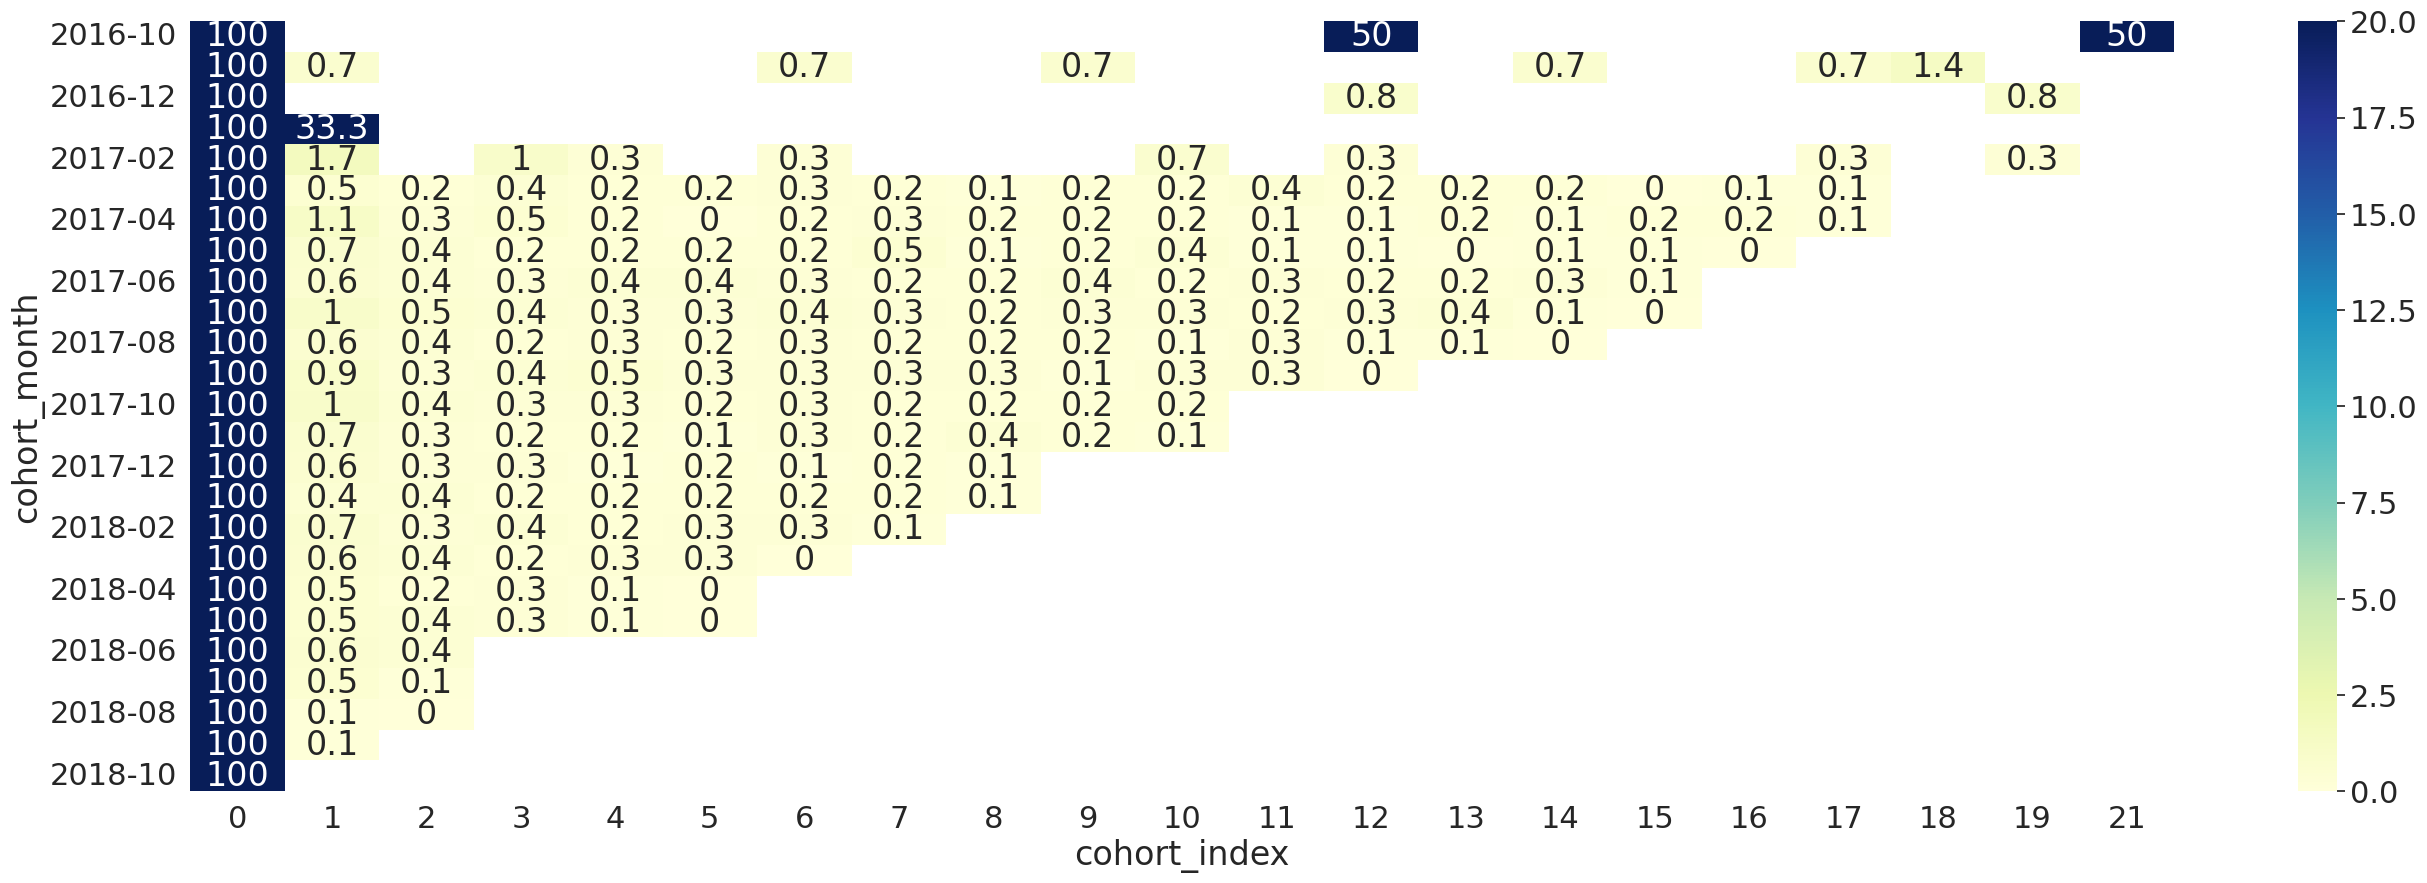

In [306]:
retention.index = retention.index.strftime('%Y-%m')
# Initialize the figure
plt.figure(figsize=(32, 10))
# Creating the heatmap
sns.heatmap(retention, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.show()

## Task 6

In [350]:
order_from_items = (
    order_items
    .merge(orders[['order_id', 'customer_id','order_estimated_delivery_date']], on = 'order_id', how = 'left')
    .merge(customer[['customer_id', 'customer_unique_id']], on = 'customer_id', how = 'left')
    .groupby(['order_id', 'order_estimated_delivery_date', 'customer_unique_id'], as_index=False)
    .agg(price = ('price', 'sum'))
)

In [351]:
NOW = order_from_items['order_estimated_delivery_date'].max() + timedelta(days=1)

In [380]:
rfm = (
    order_from_items
    .assign(order_estimated_delivery_date = lambda x: (NOW - x.order_estimated_delivery_date).dt.days)
    .groupby('customer_unique_id', as_index=False)
    .agg(
        Recency = ('order_estimated_delivery_date', 'min'),
        Frequency = ('order_id', 'count'),
        Monetary = ('price', 'sum')
    )
)

quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()



In [379]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 
    


In [378]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,158,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,567,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,347,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,325,1,180.00,2,1,5,215
